# Uncertainty Quantification Strategies in Neural Networks using TensorFlow

In this notebook we will examine a series of methods for uncertainty quantification (UQ) using neural networks in TensorFlow.

The methods that we will cover are:

* Monte Carlo Dropout
* Mixture Density Networks
* Bayesian Neural Networks

We will also examine various ways to visualize the results to gain insight.

# Generate Data

We will use sklearn to generate some surrogate regression data for testing.

In [1]:
import sklearn.datasets as sdt
import matplotlib.pyplot as plt

# Create surogate data
n_samples = 1000
n_features = 10
n_info = 5
n_targets = 3
noise = 10

x, y = sdt.make_regression(
    n_samples=n_samples, 
    n_features=n_features, 
    n_informative=n_info, 
    n_targets=n_targets, 
    noise=noise, 
    random_state=42,
)
print(f"Shape of x: {x.shape}, Shape of y: {y.shape}")

Shape of x: (1000, 10), Shape of y: (1000, 3)


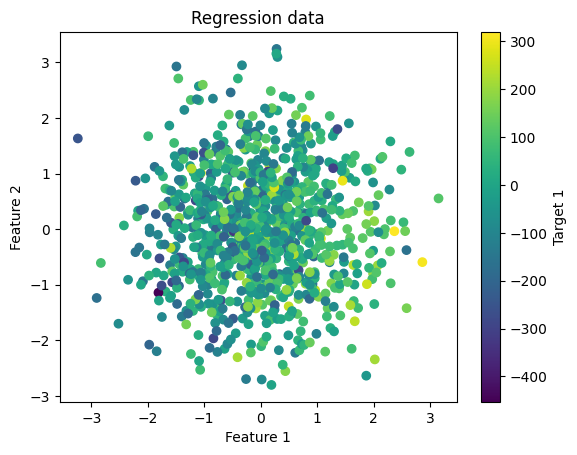

In [2]:
# Plot just the first two features
plt.scatter(x[:,0], x[:,1], c=y[:,0], cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Regression data')
plt.colorbar().set_label('Target 1')

# Preprocess Data

We will use sklearn preprocessing to scale the data.

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Scale the data
x_normalizer = StandardScaler()
y_normalizer = StandardScaler()

x_norm = x_normalizer.fit_transform(x)
y_norm = y_normalizer.fit_transform(y)

# Create the train and test datasets
x_train, x_test, y_train, y_test = train_test_split(x_norm, y_norm, test_size=0.2, random_state=42)
# Create the validation dataset from the test dataset
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

# Precompute the un-normalized data for later use
y_train_real = y_normalizer.inverse_transform(y_train)
y_test_real = y_normalizer.inverse_transform(y_test)
y_val_real = y_normalizer.inverse_transform(y_val)

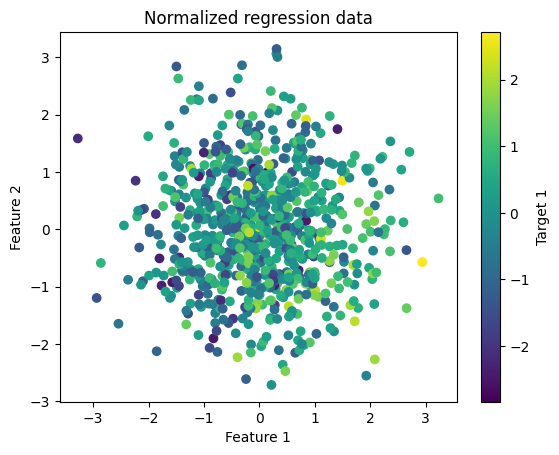

In [4]:
# Plot normalized data
plt.scatter(x_train[:,0], x_train[:,1], c=y_train[:,0], cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Normalized regression data')
plt.colorbar().set_label('Target 1')

# Building our Models

One of the strengths of neural network (NN) based methods is their inherent modularity. By developing these models in fundamental building blocks, we can see how it is relatively easy to customize them for our specific needs/goals/applications. Here we will examine a few building blocks of NNs and how they can be modified to add in uncertainty quanitification (UQ).

In [5]:
# Start with basic in tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.models import Model

class SimpleModel(Model):
    """
    Simple model with two bulk layers and one output layer. Using Dropout and ReLU
    activation. No batch normalization or other advanced techniques.
    """
    def __init__(self, width, num_targets, dropout=0.1, **kwargs):
        super(SimpleModel, self).__init__(**kwargs)
        
        self.width = width
        self.num_targets = num_targets
        self.dropout = dropout

        # Dense Layers
        self.l1 = Dense(self.width, activation=None)
        self.l2 = Dense(self.width, activation=None)
        self.l3 = Dense(self.num_targets, activation=None)

        # Activation Layers
        self.a1 = Activation('relu')
        self.a2 = Activation('relu')

        # Dropout Layers
        self.d1 = Dropout(self.dropout)
        self.d2 = Dropout(self.dropout)


    def call(self, inputs):
        x = inputs

        # First layer
        x = self.l1(x)
        x = self.a1(x)
        x = self.d1(x)

        # Second layer
        x = self.l2(x)
        x = self.a2(x)
        x = self.d2(x)

        # Output layer
        x = self.l3(x)

        return x
    
# Compile model
simple_model = SimpleModel(width=32, num_targets=n_targets, dropout=0.1)
simple_model.compile(optimizer='adam', loss='mse')
simple_model.build(input_shape=(None, n_features))
simple_model.summary()

Model: "simple_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  352       
                                                                 
 dense_1 (Dense)             multiple                  1056      
                                                                 
 dense_2 (Dense)             multiple                  99        
                                                                 
 activation (Activation)     multiple                  0         
                                                                 
 activation_1 (Activation)   multiple                  0         
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 dropout_1 (Dropout)         multiple                 

In [6]:
# Train the model
history = simple_model.fit(
    x_train, y_train, 
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=32,
)

Epoch 1/100
25/25 [==============================] - 0s 3ms/step - loss: 0.9081 - val_loss: 0.9663
Epoch 2/100
25/25 [==============================] - 0s 933us/step - loss: 0.6825 - val_loss: 0.7093
Epoch 3/100
25/25 [==============================] - 0s 899us/step - loss: 0.5035 - val_loss: 0.4459
Epoch 4/100
25/25 [==============================] - 0s 870us/step - loss: 0.3308 - val_loss: 0.2445
Epoch 5/100
25/25 [==============================] - 0s 960us/step - loss: 0.2283 - val_loss: 0.1406
Epoch 6/100
25/25 [==============================] - 0s 958us/step - loss: 0.1805 - val_loss: 0.0998
Epoch 7/100
25/25 [==============================] - 0s 927us/step - loss: 0.1558 - val_loss: 0.0828
Epoch 8/100
25/25 [==============================] - 0s 980us/step - loss: 0.1540 - val_loss: 0.0722
Epoch 9/100
25/25 [==============================] - 0s 891us/step - loss: 0.1216 - val_loss: 0.0695
Epoch 10/100
25/25 [==============================] - 0s 962us/step - loss: 0.1273 - val_loss

Text(0.5, 1.0, 'Training history')

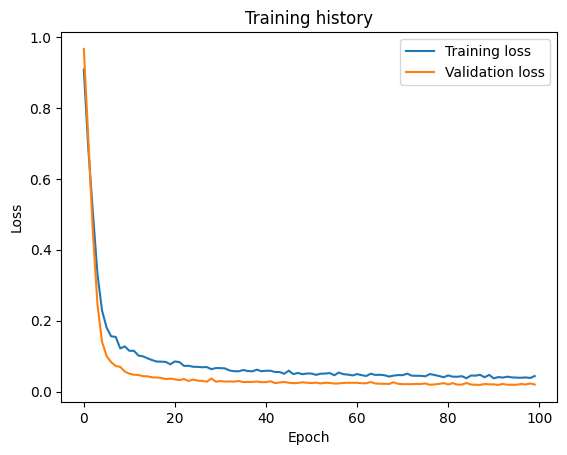

In [7]:
# Plot the training history
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training history')


In [8]:
# Evaluate the model
pred_train_norm = simple_model(x_train, training=False)
pred_test_norm = simple_model(x_test, training=False)
pred_val_norm = simple_model(x_val, training=False)

# Un-normalize the data
pred_train = y_normalizer.inverse_transform(pred_train_norm)
pred_test = y_normalizer.inverse_transform(pred_test_norm)
pred_val = y_normalizer.inverse_transform(pred_val_norm)

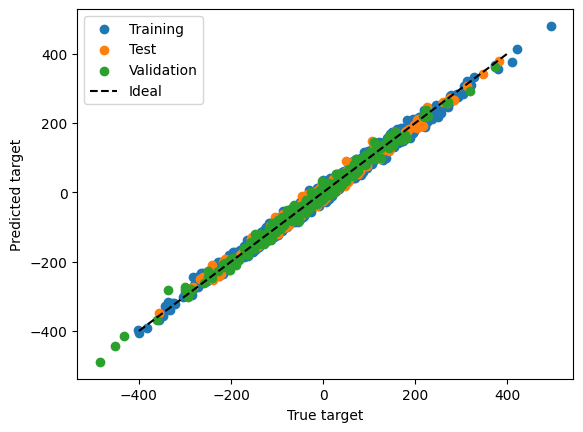

In [9]:
# Plot the results on a point-cloud plot
plt.scatter(y_train_real, pred_train, label='Training')
plt.scatter(y_test_real, pred_test, label='Test')
plt.scatter(y_val_real, pred_val, label='Validation')
plt.plot([-400, 400], [-400, 400], 'k--', label='Ideal')
plt.xlabel('True target')
plt.ylabel('Predicted target')
plt.legend()

## Make a modified version using TF-MELT Blocks

Leverage pre-defined building blocks within TF-MELT to help speed up development

In [10]:
from tfmelt.blocks import DenseBlock, DefaultOutput

class BlockModel(Model):
    """
    Model using the DenseBlock class to re-create the simple model in modular form.
    """
    def __init__(self, width, num_targets, dropout=0.1, **kwargs):
        super(BlockModel, self).__init__(**kwargs)
        
        self.width = width
        self.num_targets = num_targets
        self.dropout = dropout

        # Dense Block
        self.dense_block = DenseBlock(
            node_list = [self.width, self.width],
            activation = 'relu',
            dropout = self.dropout,
            batch_norm = False,
            regularizer = None,
            initializer = 'glorot_uniform',
        )

        # Output Block
        self.output_block = DefaultOutput(
            num_outputs = self.num_targets,
            output_activation = None,
            regularizer = None,
            initializer = 'glorot_uniform',
        )

    def call(self, inputs):
        x = inputs

        # Dense Block
        x = self.dense_block(x)

        # Output Block
        x = self.output_block(x)

        return x
    
# Compile model
block_model = BlockModel(width=32, num_targets=n_targets, dropout=0.1)
block_model.compile(optimizer='adam', loss='mse')
block_model.build(input_shape=(None, n_features))
block_model.summary()

Model: "block_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_block (DenseBlock)    multiple                  1408      
                                                                 
 default_output (DefaultOut  multiple                  99        
 put)                                                            
                                                                 
Total params: 1507 (5.89 KB)
Trainable params: 1507 (5.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
# Train the model
history = block_model.fit(
    x_train, y_train, 
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=32,
)

Epoch 1/100
25/25 [==============================] - 0s 2ms/step - loss: 0.9962 - val_loss: 1.1625
Epoch 2/100
25/25 [==============================] - 0s 995us/step - loss: 0.7420 - val_loss: 0.8721
Epoch 3/100
25/25 [==============================] - 0s 996us/step - loss: 0.5319 - val_loss: 0.5518
Epoch 4/100
25/25 [==============================] - 0s 959us/step - loss: 0.3679 - val_loss: 0.2918
Epoch 5/100
25/25 [==============================] - 0s 1ms/step - loss: 0.2378 - val_loss: 0.1642
Epoch 6/100
25/25 [==============================] - 0s 1ms/step - loss: 0.1853 - val_loss: 0.1135
Epoch 7/100
25/25 [==============================] - 0s 1ms/step - loss: 0.1554 - val_loss: 0.0872
Epoch 8/100
25/25 [==============================] - 0s 1ms/step - loss: 0.1454 - val_loss: 0.0712
Epoch 9/100
25/25 [==============================] - 0s 935us/step - loss: 0.1276 - val_loss: 0.0659
Epoch 10/100
25/25 [==============================] - 0s 993us/step - loss: 0.1160 - val_loss: 0.0620

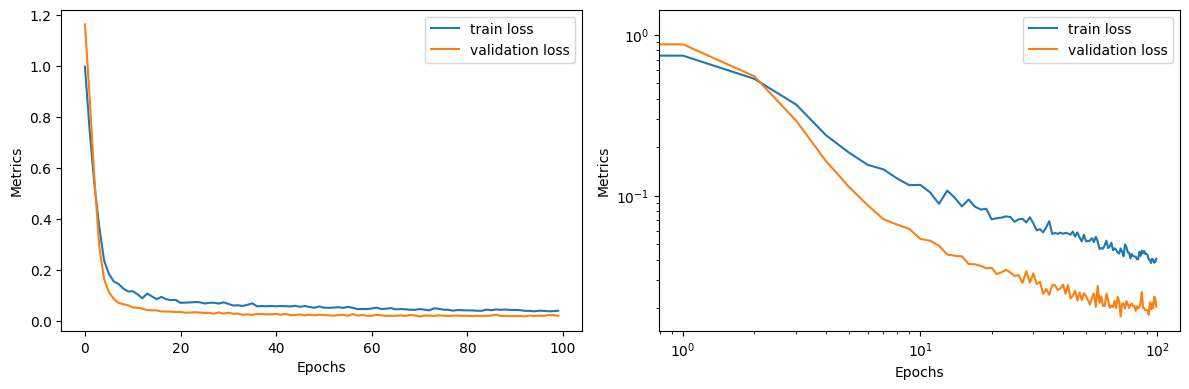

In [12]:
from tfmelt.utils.visualization import plot_history

# Plot the training history
plot_history(history, plot_log=True)

In [13]:
# Evaluate the model
pred_train_norm = block_model(x_train, training=False)
pred_test_norm = block_model(x_test, training=False)
pred_val_norm = block_model(x_val, training=False)

# Un-normalize the data
pred_train = y_normalizer.inverse_transform(pred_train_norm)
pred_test = y_normalizer.inverse_transform(pred_test_norm)
pred_val = y_normalizer.inverse_transform(pred_val_norm)

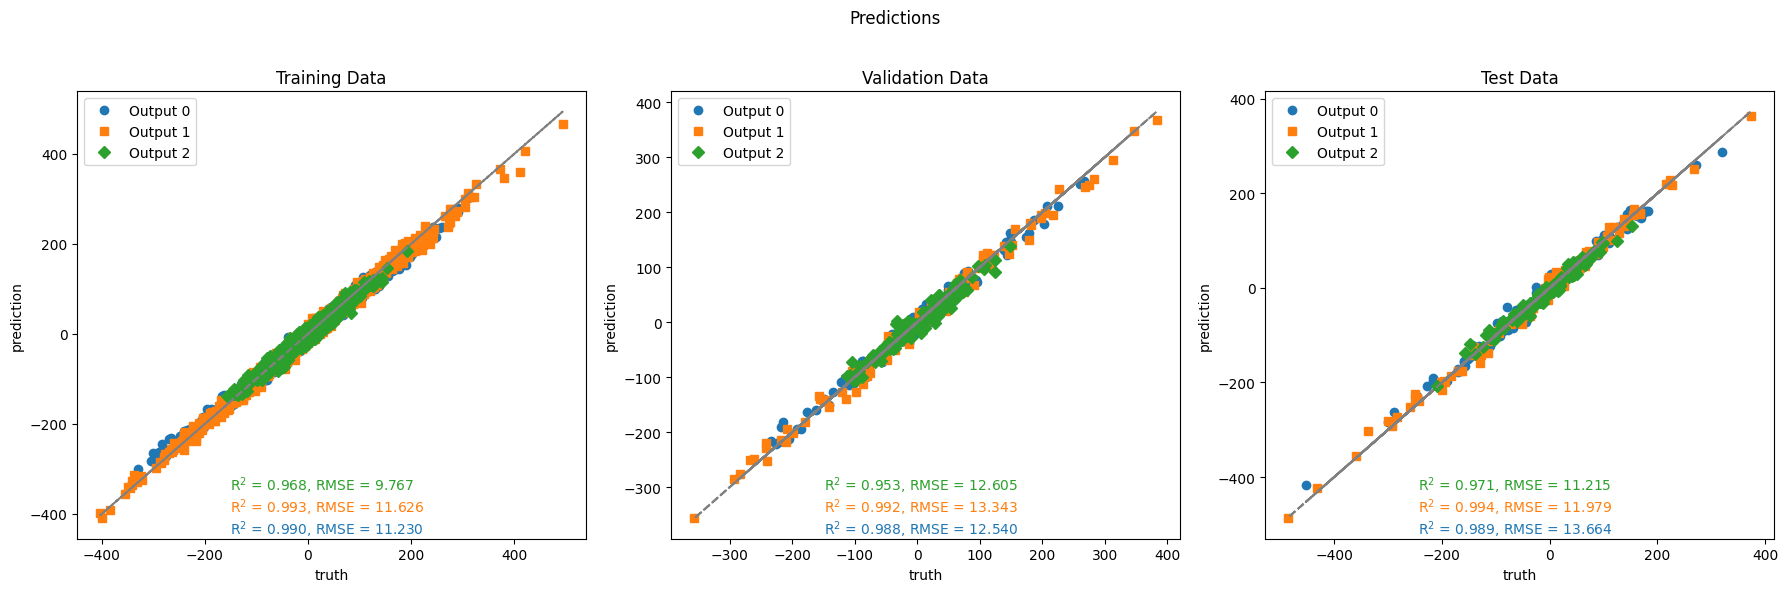

In [14]:
from tfmelt.utils.visualization import plot_predictions

# Plot the results on a point-cloud plot
plot_predictions(pred_train, y_train_real, pred_test, y_test_real, pred_val, y_val_real)

# Monte Carlo Dropout

Dropout layers are enabled during training and disabled during evaluation. If you manually enable dropout layers during evaluation you can sample the network multiple times and form an ensemble of predictions that will each represent a thinned model. From that ensemble we can evaluate statistics.

In [15]:
import numpy as np

# Evaluate the model with training enabled and form an ensemble
n_iter = 100

pred_train_list = []
pred_test_list = []
pred_val_list = []

for i in range(n_iter):
    pred_train_norm = block_model(x_train, training=True)
    pred_test_norm = block_model(x_test, training=True)
    pred_val_norm = block_model(x_val, training=True)

    pred_train = y_normalizer.inverse_transform(pred_train_norm)
    pred_test = y_normalizer.inverse_transform(pred_test_norm)
    pred_val = y_normalizer.inverse_transform(pred_val_norm)


    pred_train_list.append(pred_train)
    pred_test_list.append(pred_test)
    pred_val_list.append(pred_val)

# Average the predictions
pred_train_mean = np.mean(np.array(pred_train_list), axis=0)
pred_test_mean = np.mean(np.array(pred_test_list), axis=0)
pred_val_mean = np.mean(np.array(pred_val_list), axis=0)

# Calculate the standard deviation
pred_train_std = np.std(np.array(pred_train_list), axis=0)
pred_test_std = np.std(np.array(pred_test_list), axis=0)
pred_val_std = np.std(np.array(pred_val_list), axis=0)


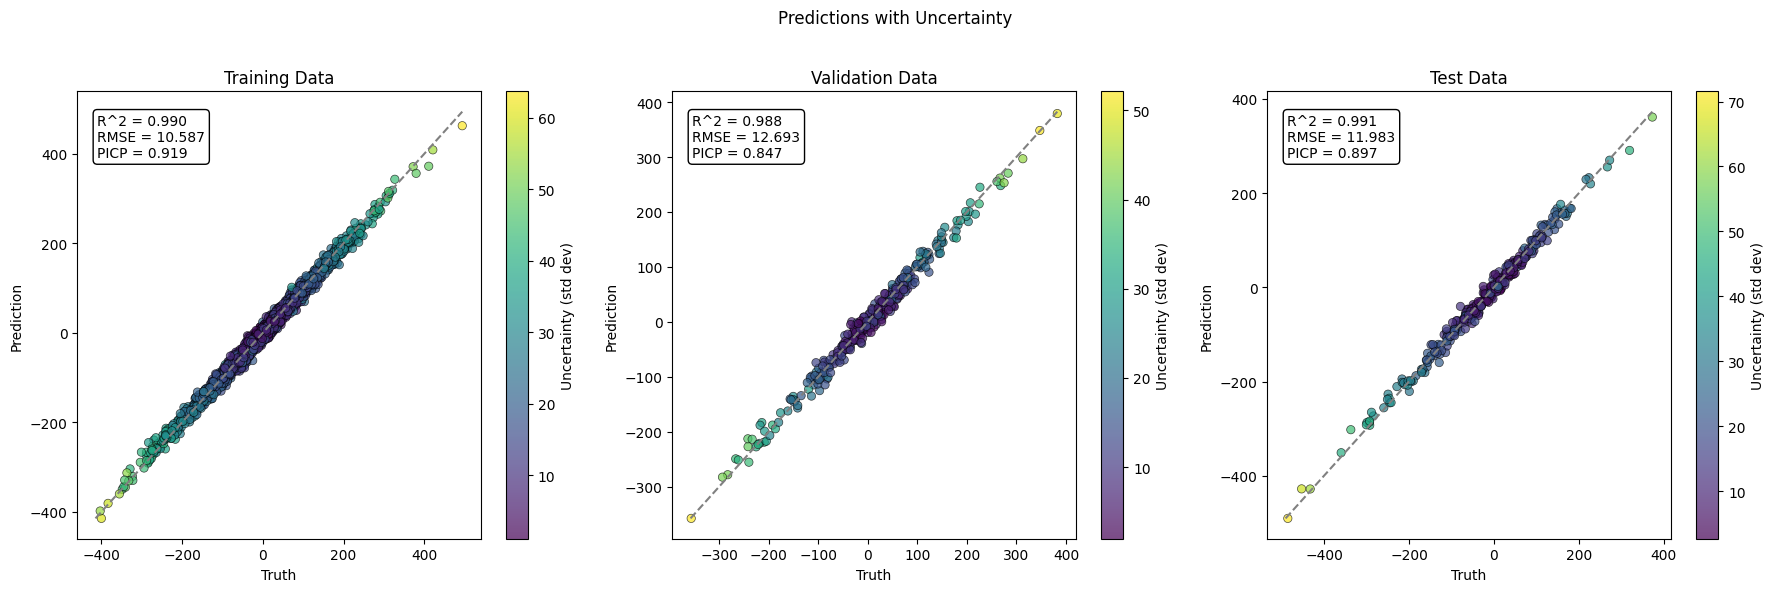

In [16]:
from tfmelt.utils.visualization import plot_predictions_with_uncertainty

# Plot MC Dropout results
plot_predictions_with_uncertainty(
    pred_train_mean, pred_train_std, y_train_real,
    pred_test_mean, pred_test_std, y_test_real,
    pred_val_mean, pred_val_std, y_val_real,
    metrics_to_display=["R^2", "RMSE", "PICP"],
)

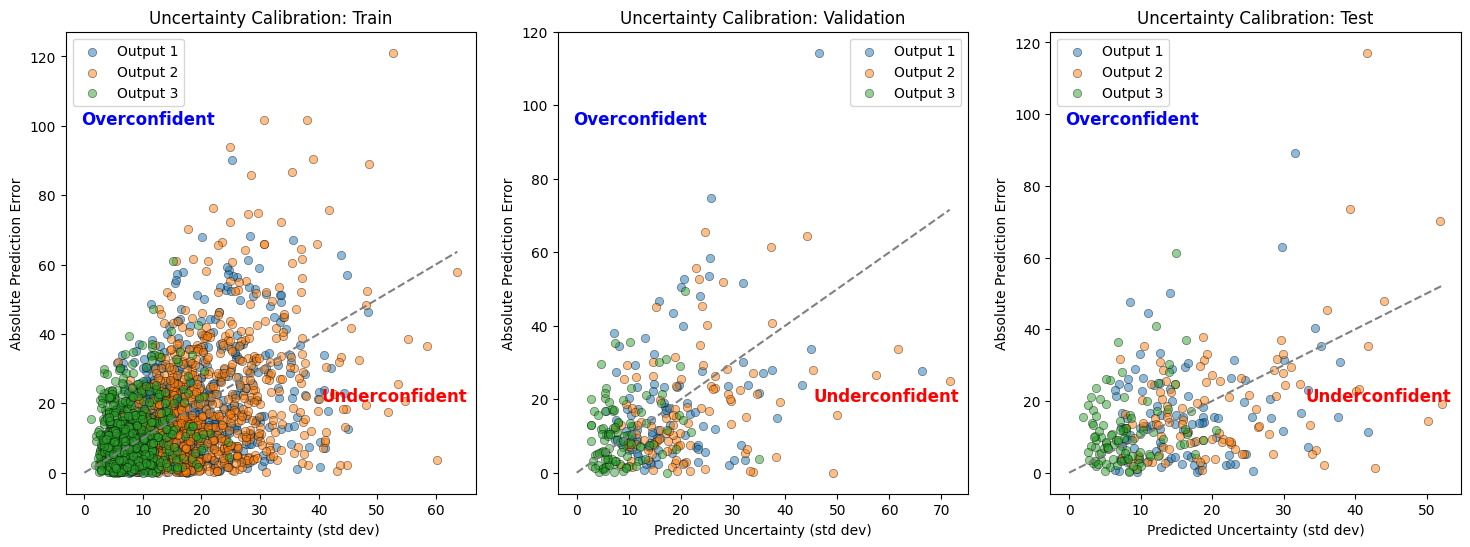

In [17]:
from tfmelt.utils.visualization import plot_uncertainty_calibration

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

plot_uncertainty_calibration(ax[0], y_train_real, pred_train, pred_train_std, dataset_name='Train')
plot_uncertainty_calibration(ax[1], y_val_real, pred_val, pred_val_std, dataset_name='Validation')
plot_uncertainty_calibration(ax[2], y_test_real, pred_test, pred_test_std, dataset_name='Test')


# Heteroscedastic Neural Networks and Mixture Density Networks

Now, let's look at how to form UQ estimates by modifying the output of a block NN without having to create an ensemble. Here, we will directly predict both the value and the uncertainty of that value through a negative log-likelihood loss function.

In [20]:
from tfmelt.blocks import DenseBlock
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

class HNNModel(Model):
    def __init__(self, width, num_targets, dropout=0.0, **kwargs):
        super(HNNModel, self).__init__(**kwargs)
        
        self.width = width
        self.num_targets = num_targets
        self.dropout = dropout

        # Dense Block
        self.dense_block = DenseBlock(
            node_list = [self.width, self.width],
            activation = 'relu',
            dropout = self.dropout,
            batch_norm = False,
            regularizer = None,
            initializer = 'glorot_uniform',
        )

        # Output layer
        self.output_layer = Dense(2 * self.num_targets, activation=None)

    def call(self, inputs):
        x = inputs

        # Dense Block
        x = self.dense_block(x)

        # Output layer
        x = self.output_layer(x)

        return x
    
    def hnn_loss(self, y_true, y_pred):

        # Split the predictions into the mean and the log-variance
        y_pred_mean = y_pred[:, :self.num_targets]
        y_pred_log_var = y_pred[:, self.num_targets:]

        # Calculate the variance (clipped to avoid NaNs)
        y_pred_var = tf.exp(tf.clip_by_value(y_pred_log_var, -20, 20))

        # Calculate the loss
        loss = -0.5 * tf.reduce_mean(tf.square((y_true - y_pred_mean) / y_pred_var) + y_pred_log_var)

        return -loss
    
    def compile(self, optimizer, **kwargs):
        super(HNNModel, self).compile(**kwargs)
        self.optimizer = optimizer

# Compile model
hnn_model = HNNModel(width=32, num_targets=n_targets, dropout=0.1)
hnn_model.compile(optimizer=Adam(lr=1e-3), loss=hnn_model.hnn_loss)
hnn_model.build(input_shape=(None, n_features))
hnn_model.summary()

Model: "hnn_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_block_2 (DenseBlock)  multiple                  1408      
                                                                 
 dense_4 (Dense)             multiple                  198       
                                                                 
Total params: 1606 (6.27 KB)
Trainable params: 1606 (6.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
# Train the model
history = hnn_model.fit(
    x_train, y_train, 
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=32,
)

Epoch 1/100
25/25 [==============================] - 0s 3ms/step - loss: 0.5525 - val_loss: 0.5561
Epoch 2/100
25/25 [==============================] - 0s 1ms/step - loss: 0.4476 - val_loss: 0.5068
Epoch 3/100
25/25 [==============================] - 0s 963us/step - loss: 0.3986 - val_loss: 0.4594
Epoch 4/100
25/25 [==============================] - 0s 932us/step - loss: 0.3662 - val_loss: 0.4089
Epoch 5/100
25/25 [==============================] - 0s 808us/step - loss: 0.3195 - val_loss: 0.3396
Epoch 6/100
25/25 [==============================] - 0s 850us/step - loss: 0.2607 - val_loss: 0.2500
Epoch 7/100
25/25 [==============================] - 0s 923us/step - loss: 0.2007 - val_loss: 0.1421
Epoch 8/100
25/25 [==============================] - 0s 885us/step - loss: 0.1217 - val_loss: 0.0382
Epoch 9/100
25/25 [==============================] - 0s 811us/step - loss: 0.0650 - val_loss: -0.0360
Epoch 10/100
25/25 [==============================] - 0s 909us/step - loss: 0.0162 - val_loss:

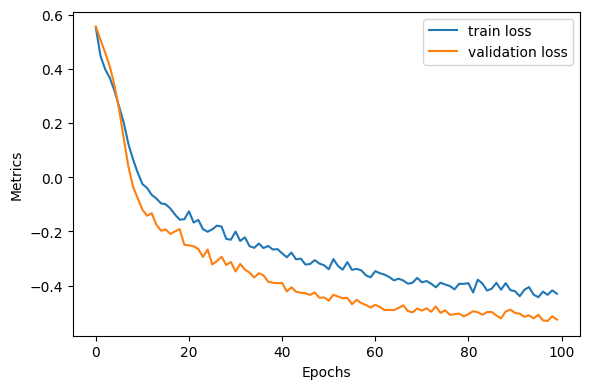

In [22]:
# Plot the training history
plot_history(history, plot_log=False)

In [23]:
# Evaluate the model
pred_train_norm = hnn_model(x_train, training=False)
pred_test_norm = hnn_model(x_test, training=False)
pred_val_norm = hnn_model(x_val, training=False)

# Un-normalize the data
pred_train = y_normalizer.inverse_transform(pred_train_norm[:, :n_targets])
pred_test = y_normalizer.inverse_transform(pred_test_norm[:, :n_targets])
pred_val = y_normalizer.inverse_transform(pred_val_norm[:, :n_targets])

# Un-normalize the log-variance
pred_train_std_norm = np.exp(pred_train_norm[:, n_targets:])
pred_test_std_norm = np.exp(pred_test_norm[:, n_targets:])
pred_val_std_norm = np.exp(pred_val_norm[:, n_targets:])
pred_train_std = np.float32(y_normalizer.scale_) * pred_train_std_norm
pred_test_std = np.float32(y_normalizer.scale_) * pred_test_std_norm
pred_val_std = np.float32(y_normalizer.scale_) * pred_val_std_norm


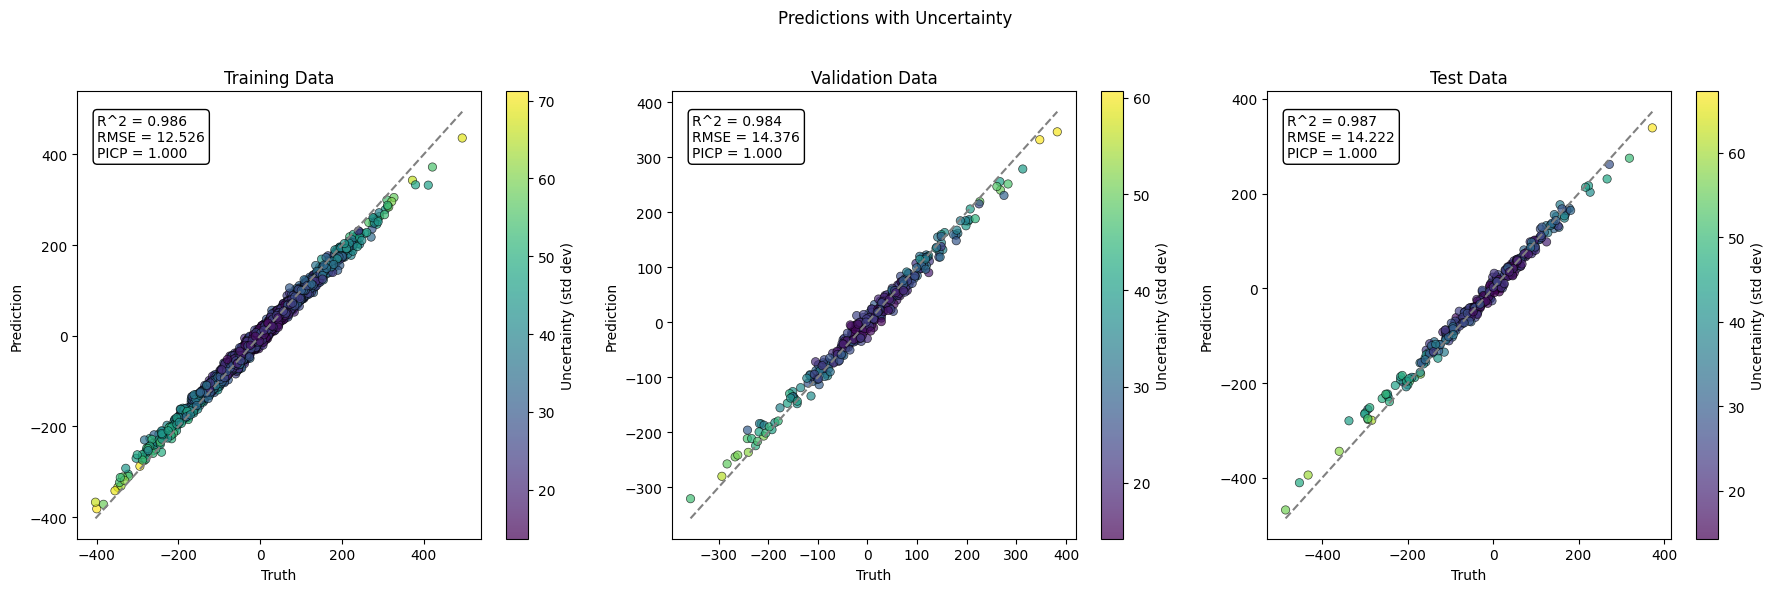

In [24]:
from tfmelt.utils.visualization import plot_predictions_with_uncertainty

# Plot the results on a point-cloud plot
plot_predictions_with_uncertainty(
    pred_train, pred_train_std, y_train_real,
    pred_test, pred_test_std, y_test_real,
    pred_val, pred_val_std, y_val_real,
    metrics_to_display=["R^2", "RMSE", "PICP"],
)

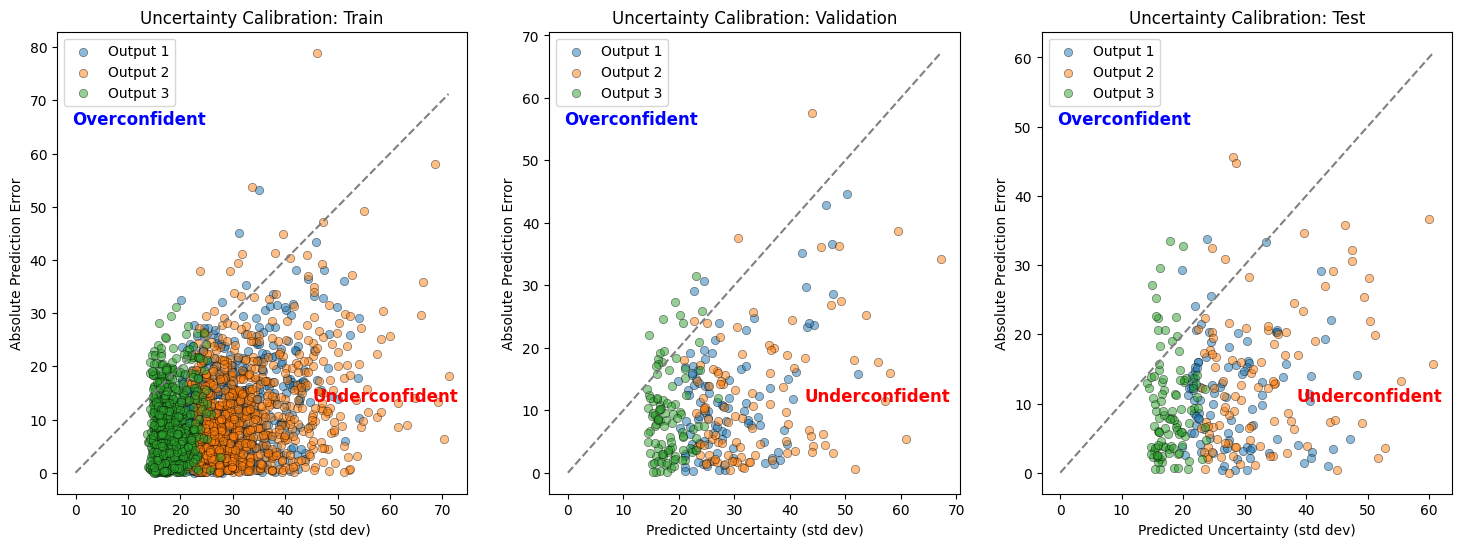

In [25]:
from tfmelt.utils.visualization import plot_uncertainty_calibration

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

plot_uncertainty_calibration(ax[0], y_train_real, pred_train, pred_train_std, dataset_name='Train')
plot_uncertainty_calibration(ax[1], y_val_real, pred_val, pred_val_std, dataset_name='Validation')
plot_uncertainty_calibration(ax[2], y_test_real, pred_test, pred_test_std, dataset_name='Test')


## Mixture Density Network

A mixture density network (MDN) is an extension of the HNN to multiple guassian distributions, where the loss function is modified to be a weighted average over the multiple learned distributions. For brevity, we will first show that the above model can be reproduced with a TF-MELT block, and then demonstrate that block with multiple mixtures.

In [26]:
from tfmelt.models import ArtificialNeuralNetwork

# Create the model
mdn_model = ArtificialNeuralNetwork(
    num_outputs=n_targets,
    node_list=[32, 32],
    act_fun='relu',
    dropout=0.1,
    batch_norm=False,
    output_activation=None,
    initializer='glorot_uniform',
    num_mixtures=5,
)

# Compile the model
mdn_model.compile(optimizer=Adam(lr=1e-3))
mdn_model.build(input_shape=(None, n_features))
mdn_model.summary()

Model: "artificial_neural_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mixture_density_output (Mi  multiple                  1155      
 xtureDensityOutput)                                             
                                                                 
 dense_block (DenseBlock)    multiple                  1408      
                                                                 
Total params: 2563 (10.01 KB)
Trainable params: 2563 (10.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "mixture_density_output"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mix_coeffs (Dense)          multiple                  165       
                                                                 
 mean_output (Dense)         multiple    

/Users/nwimer/miniconda3/envs/nrel-ai/lib/python3.11/site-packages/tfmelt/models.py:182: UserWarning: Loss function is overridden when using mixture density networks. Using the mixture density loss function.
  warnings.warn(


In [27]:
# Train the model
history = mdn_model.fit(
    x_train, y_train, 
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=32,
)

Epoch 1/100
25/25 [==============================] - 1s 9ms/step - loss: 3.2205 - val_loss: 3.3345
Epoch 2/100
25/25 [==============================] - 0s 1ms/step - loss: 3.1154 - val_loss: 3.2015
Epoch 3/100
25/25 [==============================] - 0s 1ms/step - loss: 2.9546 - val_loss: 2.9401
Epoch 4/100
25/25 [==============================] - 0s 1ms/step - loss: 2.7202 - val_loss: 2.5711
Epoch 5/100
25/25 [==============================] - 0s 1ms/step - loss: 2.5201 - val_loss: 2.3842
Epoch 6/100
25/25 [==============================] - 0s 1ms/step - loss: 2.4642 - val_loss: 2.3028
Epoch 7/100
25/25 [==============================] - 0s 931us/step - loss: 2.4028 - val_loss: 2.2210
Epoch 8/100
25/25 [==============================] - 0s 955us/step - loss: 2.3270 - val_loss: 2.1175
Epoch 9/100
25/25 [==============================] - 0s 986us/step - loss: 2.2769 - val_loss: 2.0941
Epoch 10/100
25/25 [==============================] - 0s 966us/step - loss: 2.2618 - val_loss: 2.1173
E

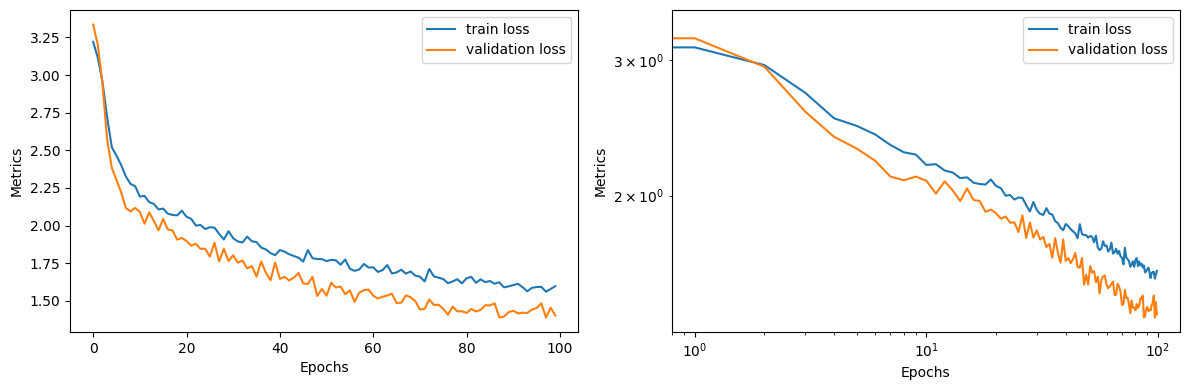

In [28]:
# Plot the training history
plot_history(history, plot_log=True)

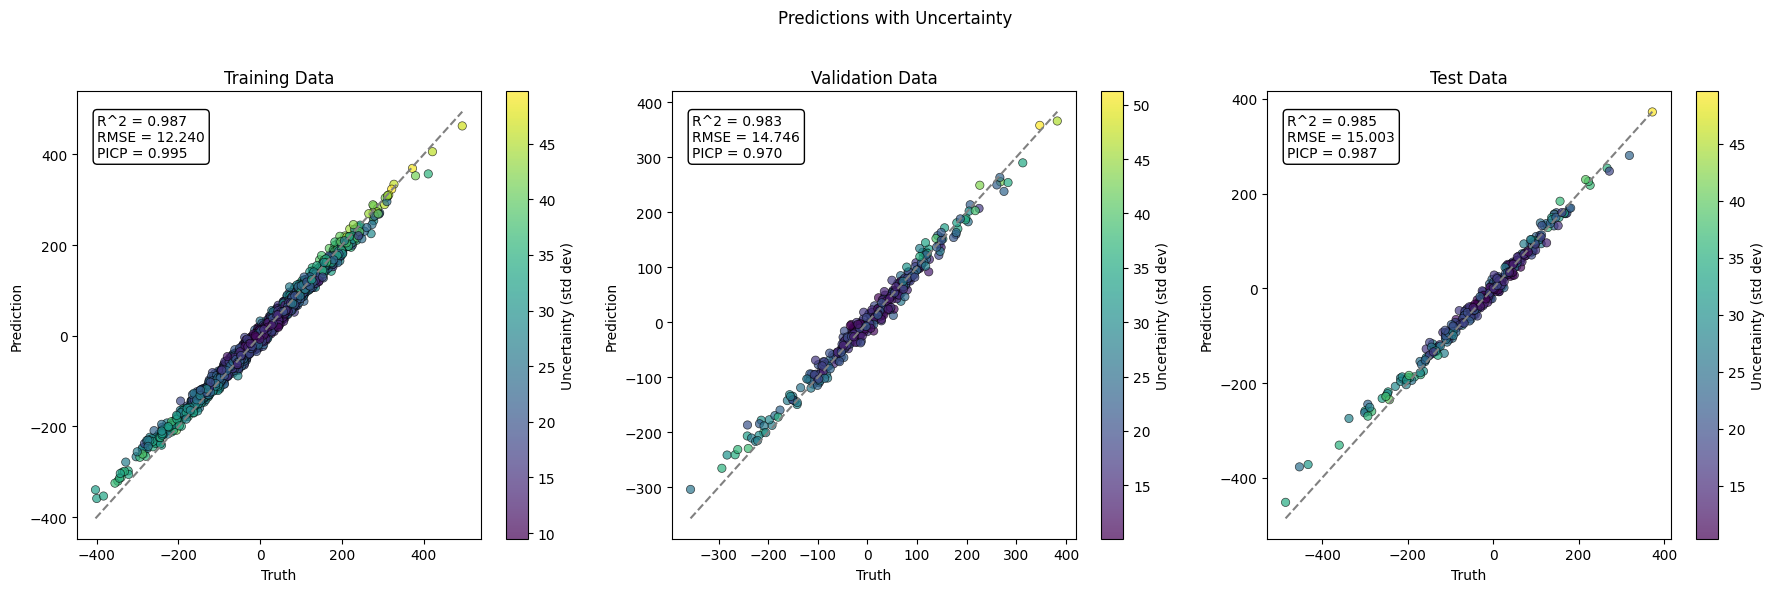

In [29]:
from tfmelt.utils.evaluation import make_predictions
from tfmelt.utils.visualization import plot_predictions_with_uncertainty

# Evaluate the model
pred_train, pred_train_std = make_predictions(mdn_model, x_train, y_normalizer, unnormalize=True)
pred_test, pred_test_std = make_predictions(mdn_model, x_test, y_normalizer, unnormalize=True)
pred_val, pred_val_std = make_predictions(mdn_model, x_val, y_normalizer, unnormalize=True)

# plot the results on a point-cloud plot
plot_predictions_with_uncertainty(
    pred_train, pred_train_std, y_train_real,
    pred_test, pred_test_std, y_test_real,
    pred_val, pred_val_std, y_val_real,
    metrics_to_display=["R^2", "RMSE", "PICP"],
)


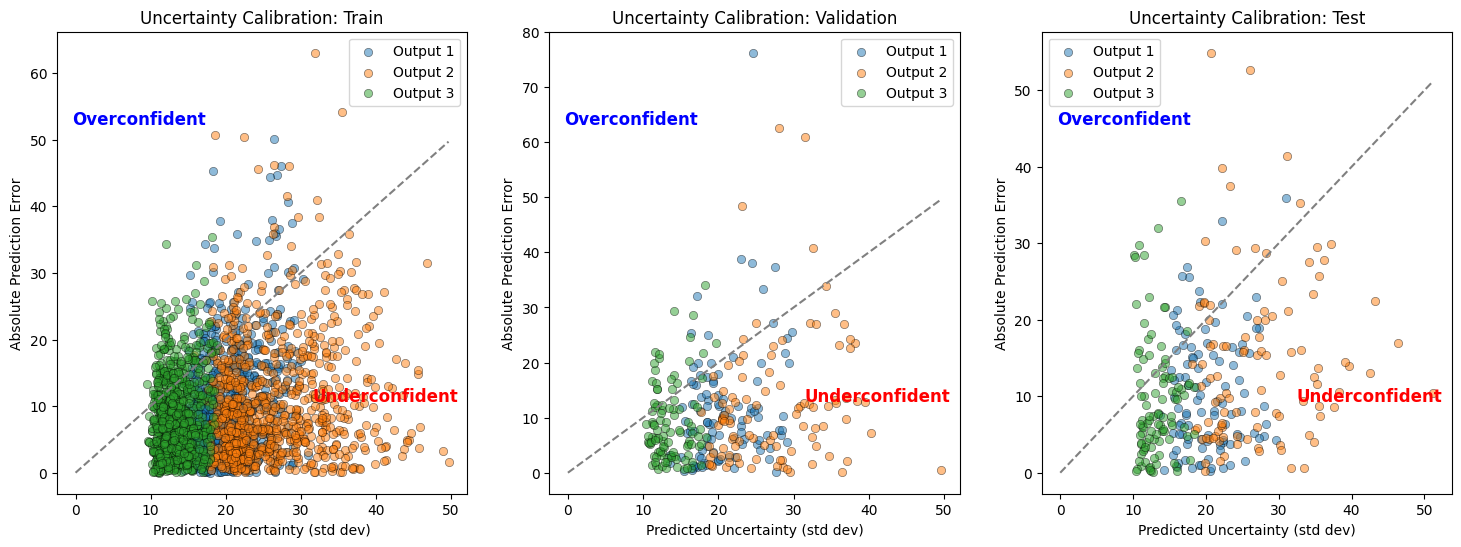

In [30]:
from tfmelt.utils.visualization import plot_uncertainty_calibration

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

plot_uncertainty_calibration(ax[0], y_train_real, pred_train, pred_train_std, dataset_name='Train')
plot_uncertainty_calibration(ax[1], y_val_real, pred_val, pred_val_std, dataset_name='Validation')
plot_uncertainty_calibration(ax[2], y_test_real, pred_test, pred_test_std, dataset_name='Test')


# Bayesian Neural Networks

The Bayesian Neural Networks are implemented through the tensorflow probability package. The particular version of the implementation is through Variational Flipout via the DenseFlipout layers.

In [46]:
import tensorflow_probability as tfp

# Create the model
class BNN(Model):
    def __init__(self, width, num_targets, dropout=0.1, n_samples=1, **kwargs):
        super(BNN, self).__init__(**kwargs)
        
        self.width = width
        self.num_targets = num_targets
        self.dropout = dropout

        # Create the kernel divergence function
        kernel_divergence_fn = lambda q, p, _: tfp.distributions.kl_divergence(q, p) / tf.cast(n_samples, tf.float32)

        # Flipout Dense Layers
        self.l1 = tfp.layers.DenseFlipout(self.width, activation='relu', kernel_divergence_fn=kernel_divergence_fn)
        self.l2 = tfp.layers.DenseFlipout(self.width, activation='relu', kernel_divergence_fn=kernel_divergence_fn)
        self.l3 = tfp.layers.DenseFlipout(self.num_targets, activation=None, kernel_divergence_fn=kernel_divergence_fn)

    def call(self, inputs):
        x = inputs

        # First layer
        x = self.l1(x)

        # Second layer
        x = self.l2(x)

        # Output layer
        x = self.l3(x)

        return x
    
# Compile model
bnn_model = BNN(width=32, num_targets=n_targets, dropout=0.1, n_samples=x_train.shape[0])
bnn_model.compile(optimizer=Adam(lr=1e-3), loss='mse')
bnn_model.build(input_shape=(None, n_features))
bnn_model.summary()

Model: "bnn_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_flipout_6 (DenseFlip  multiple                  672       
 out)                                                            
                                                                 
 dense_flipout_7 (DenseFlip  multiple                  2080      
 out)                                                            
                                                                 
 dense_flipout_8 (DenseFlip  multiple                  195       
 out)                                                            
                                                                 
Total params: 2947 (11.51 KB)
Trainable params: 2947 (11.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


/Users/nwimer/miniconda3/envs/nrel-ai/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/Users/nwimer/miniconda3/envs/nrel-ai/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


In [47]:
# Train the model
history = bnn_model.fit(
    x_train, y_train, 
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=32,
)

Epoch 1/100
25/25 [==============================] - 1s 8ms/step - loss: 5.4776 - val_loss: 5.8128
Epoch 2/100
25/25 [==============================] - 0s 1ms/step - loss: 5.3512 - val_loss: 5.6006
Epoch 3/100
25/25 [==============================] - 0s 1ms/step - loss: 5.1387 - val_loss: 5.2010
Epoch 4/100
25/25 [==============================] - 0s 1ms/step - loss: 4.8083 - val_loss: 4.6578
Epoch 5/100
25/25 [==============================] - 0s 1ms/step - loss: 4.5250 - val_loss: 4.4661
Epoch 6/100
25/25 [==============================] - 0s 1ms/step - loss: 4.4443 - val_loss: 4.4119
Epoch 7/100
25/25 [==============================] - 0s 1ms/step - loss: 4.3818 - val_loss: 4.3737
Epoch 8/100
25/25 [==============================] - 0s 1ms/step - loss: 4.3401 - val_loss: 4.3355
Epoch 9/100
25/25 [==============================] - 0s 1ms/step - loss: 4.2975 - val_loss: 4.2944
Epoch 10/100
25/25 [==============================] - 0s 1ms/step - loss: 4.2553 - val_loss: 4.2436
Epoch 11/

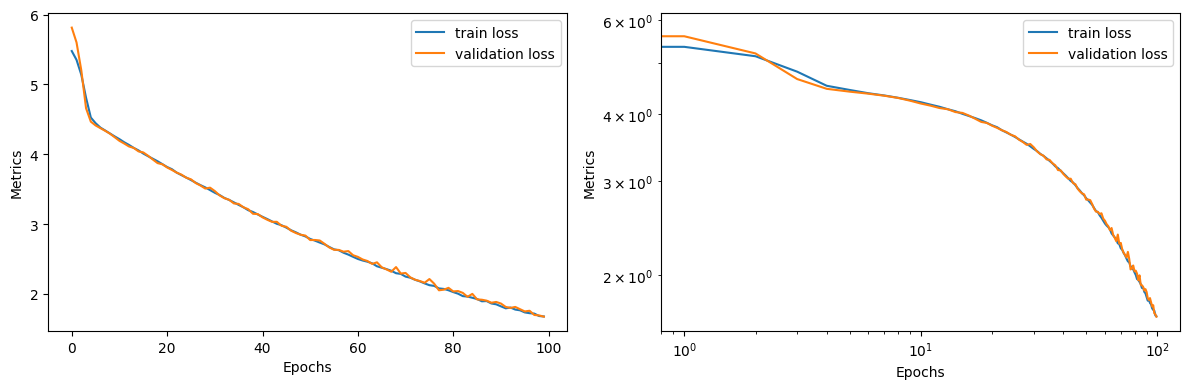

In [48]:
# Plot the training history
plot_history(history, plot_log=True)

In [49]:
# Evaluate the model using ensemble predictions
n_iter = 100

pred_train_list = []
pred_test_list = []
pred_val_list = []

for i in range(n_iter):
    pred_train = bnn_model(x_train, training=True)
    pred_test = bnn_model(x_test, training=True)
    pred_val = bnn_model(x_val, training=True)

    pred_train = y_normalizer.inverse_transform(pred_train)
    pred_test = y_normalizer.inverse_transform(pred_test)
    pred_val = y_normalizer.inverse_transform(pred_val)

    pred_train_list.append(pred_train)
    pred_test_list.append(pred_test)
    pred_val_list.append(pred_val)

# Average the predictions
pred_train_mean = np.mean(np.array(pred_train_list), axis=0)
pred_test_mean = np.mean(np.array(pred_test_list), axis=0)
pred_val_mean = np.mean(np.array(pred_val_list), axis=0)

# Calculate the standard deviation
pred_train_std = np.std(np.array(pred_train_list), axis=0)
pred_test_std = np.std(np.array(pred_test_list), axis=0)
pred_val_std = np.std(np.array(pred_val_list), axis=0)



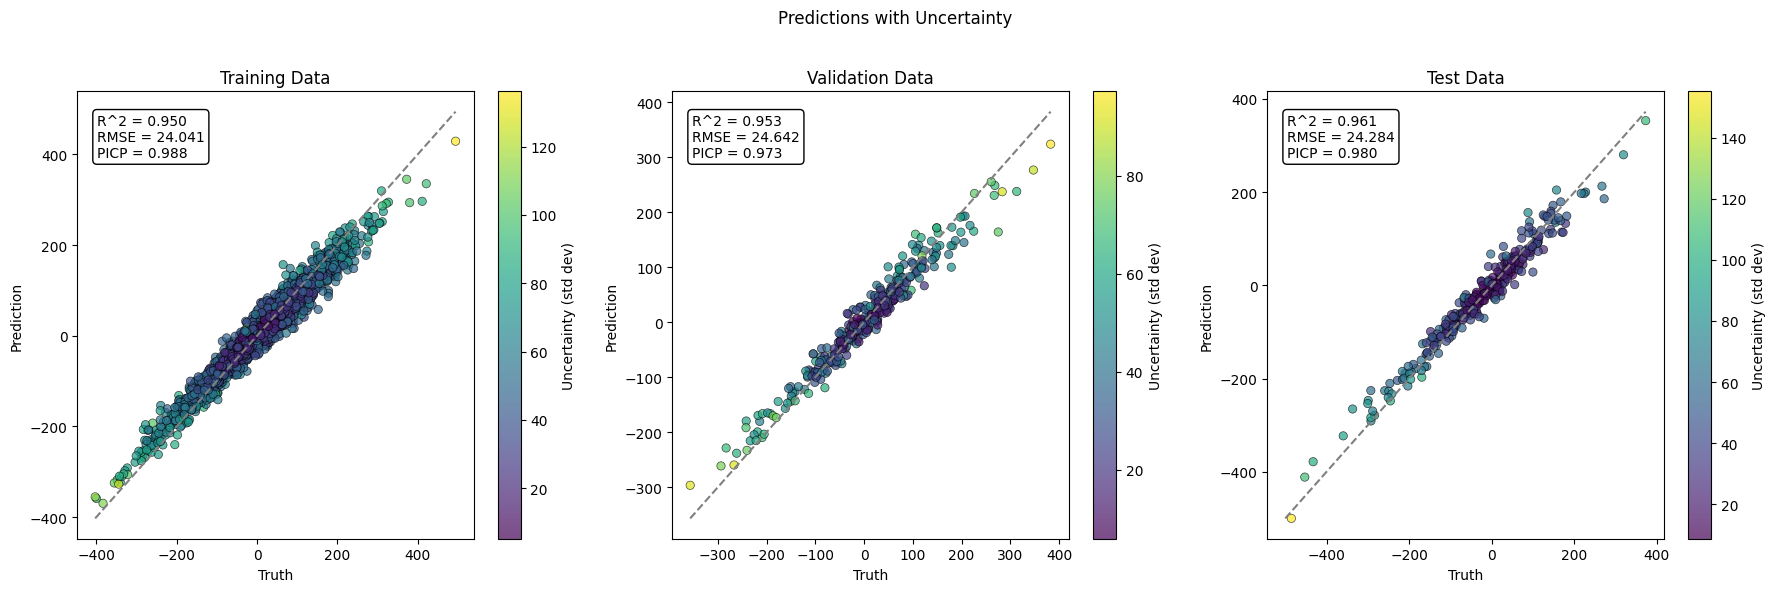

In [50]:
# Plot the point cloud with uncertainty
plot_predictions_with_uncertainty(
    pred_train_mean, pred_train_std, y_train_real,
    pred_test_mean, pred_test_std, y_test_real,
    pred_val_mean, pred_val_std, y_val_real,
    metrics_to_display=["R^2", "RMSE", "PICP"],
)

## Mixed Bayesian and Dense Layers

Some applications might be able to benefit from only a single bayesian layer or a mixture of dense and bayesian layers. Here we can use TF-MELT to experiment.

In [57]:
from tfmelt.models import BayesianNeuralNetwork

# Create the model
bnn_model = BayesianNeuralNetwork(
    num_outputs=n_targets,
    node_list=[32, 32],
    bayesian_mask=[False, False],
    do_bayesian_output=True,
    act_fun='relu',
    dropout=0.0,
    batch_norm=False,
    output_activation=None,
    initializer='glorot_uniform',
    num_points=x_train.shape[0],
)

# Compile the model
bnn_model.compile(optimizer=Adam(lr=1e-3))
bnn_model.build(input_shape=(None, n_features))
bnn_model.summary()

Model: "bayesian_neural_network_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 output (DefaultOutput)      multiple                  195       
                                                                 
 dense_block_0 (DenseBlock)  multiple                  1408      
                                                                 
Total params: 1603 (6.26 KB)
Trainable params: 1603 (6.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "output"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bayesian_output (DenseFlip  multiple                  195       
 out)                                                            
                                                                 
Total params: 195 (780.00 Byte)
Trainable params: 195 (780.

/Users/nwimer/miniconda3/envs/nrel-ai/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/Users/nwimer/miniconda3/envs/nrel-ai/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


In [58]:
# Train the model
history = bnn_model.fit(
    x_train, y_train, 
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=32,
)

Epoch 1/100
25/25 [==============================] - 0s 4ms/step - loss: 1.2388 - val_loss: 1.4585
Epoch 2/100
25/25 [==============================] - 0s 1ms/step - loss: 1.0719 - val_loss: 1.2068
Epoch 3/100
25/25 [==============================] - 0s 1ms/step - loss: 0.8582 - val_loss: 0.8201
Epoch 4/100
25/25 [==============================] - 0s 1ms/step - loss: 0.5971 - val_loss: 0.5148
Epoch 5/100
25/25 [==============================] - 0s 951us/step - loss: 0.4555 - val_loss: 0.4439
Epoch 6/100
25/25 [==============================] - 0s 1ms/step - loss: 0.4149 - val_loss: 0.4179
Epoch 7/100
25/25 [==============================] - 0s 1ms/step - loss: 0.3980 - val_loss: 0.3915
Epoch 8/100
25/25 [==============================] - 0s 1ms/step - loss: 0.3800 - val_loss: 0.3771
Epoch 9/100
25/25 [==============================] - 0s 1ms/step - loss: 0.3672 - val_loss: 0.3758
Epoch 10/100
25/25 [==============================] - 0s 1ms/step - loss: 0.3582 - val_loss: 0.3569
Epoch 1

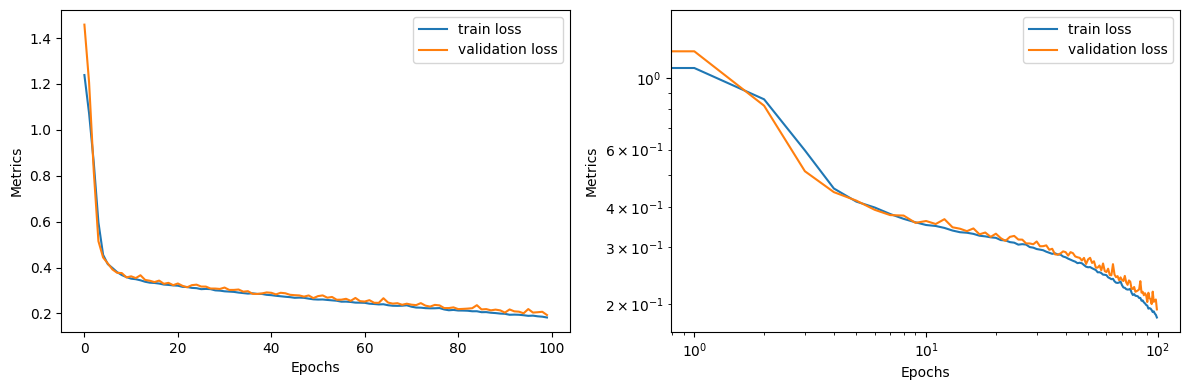

In [59]:
# Plot the training history
plot_history(history, plot_log=True)

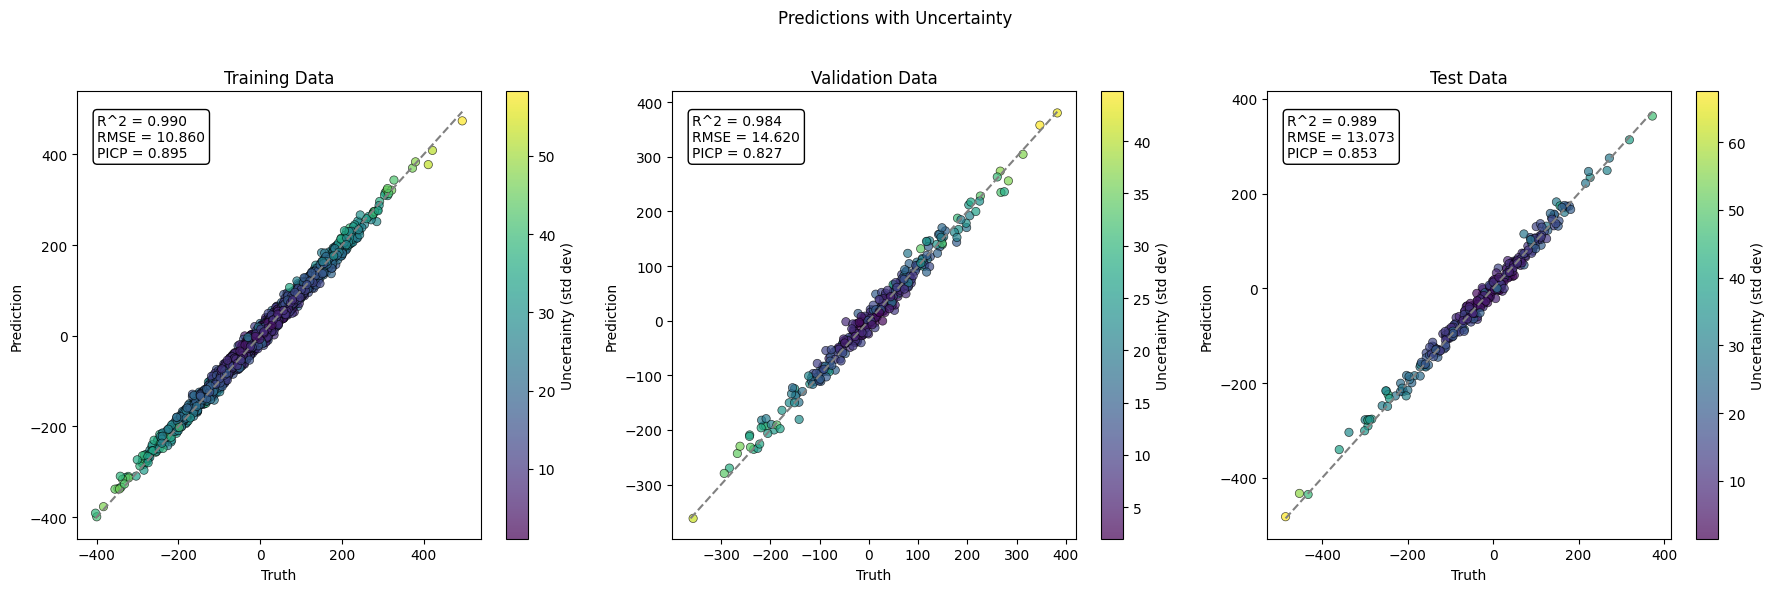

In [61]:
from tfmelt.utils.evaluation import ensemble_predictions
from tfmelt.utils.visualization import plot_predictions_with_uncertainty

# Evaluate the model
n_iter = 100
pred_train, pred_train_std = ensemble_predictions(bnn_model, x_train, y_normalizer, unnormalize=True, n_iter=n_iter, training=False)
pred_test, pred_test_std = ensemble_predictions(bnn_model, x_test, y_normalizer, unnormalize=True, n_iter=n_iter, training=False)
pred_val, pred_val_std = ensemble_predictions(bnn_model, x_val, y_normalizer, unnormalize=True, n_iter=n_iter, training=False)

# Plot the results on a point-cloud plot
plot_predictions_with_uncertainty(
    pred_train, pred_train_std, y_train_real,
    pred_test, pred_test_std, y_test_real,
    pred_val, pred_val_std, y_val_real,
    metrics_to_display=["R^2", "RMSE", "PICP"],
)

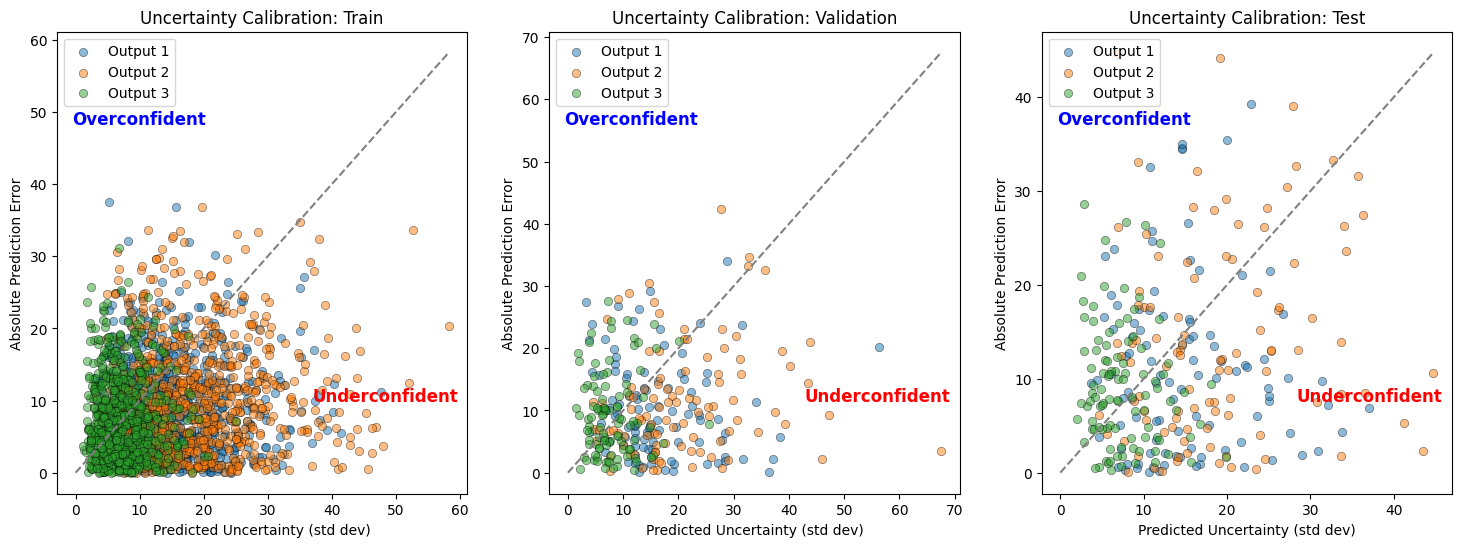

In [64]:
from tfmelt.utils.visualization import plot_uncertainty_calibration

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

plot_uncertainty_calibration(ax[0], y_train_real, pred_train, pred_train_std, dataset_name='Train')
plot_uncertainty_calibration(ax[1], y_val_real, pred_val, pred_val_std, dataset_name='Validation')
plot_uncertainty_calibration(ax[2], y_test_real, pred_test, pred_test_std, dataset_name='Test')
